## Classical Inferrence & Hypothesis Testing

Classical inferrence typically compares two hypotheses which sum to the universe of outcomes:
1. The `null` hypothesis: some default position about an observable random variable (e.g. this coin is 'fair')
2. The alternative hypothesis: typically the one we care about/argue for, a position that exactly contradicts the `null` hypothesis (e.g. this coin is not fair)


In [1]:
# Awful hack to import past chapter modules
import sys
sys.path.insert(0, "../")

from typing import Tuple
import math, random
from probability import normal_cdf, inverse_normal_cdf, binomial
from matplotlib import pyplot as plt
import numpy as np

In [2]:
def normal_approximation_to_binomial(n:int, p:float = 0.5) -> Tuple[float, float]:
    """
    Returns mu and sigma corresponding to a normal distribution approximating X~Binomial(n, p)
    """
    # expected value of X
    mu = p * n
    sigma = math.sqrt(n * p * (1 - p)) # remember, variance of Bernoulli is p * (1-p)
    return mu, sigma

The normal CDF gives the probability that X <= x_hat for a variable X ~ Normal(mu, sigma). Whenever a random variable follows a normal distribution, we can use `normal_cdf` to figure out the probability that its realized value `X` lies within OR outside a particular interval `(lower, higher)` by doing the following:

1. Let `A` = `normal_cdf(lower, mu, sigma)`. `A` gives to probabilty `X` is less than `lower`
2. Let `B` = `normal_cdf(higher, mu, sigma)`. `1 - B` gives to probabilty `X` is higher than `higher`
3. P(Outside bounds) = `A + B`, P(Inside Bounds) = `1 - A - B`


In [3]:
def normal_probability_below(lo: float, mu:float = 0, sigma:float = 1) -> float:
    """
    Returns the probability that N(mu, sigma) is less than lo
    """
    return normal_cdf(lo, mu, sigma)

def normal_probability_above(lo: float, mu:float = 0, sigma:float = 1) -> float:
    """
    Returns the probability that N(mu, sigma) is greater than lo
    """
    return 1 - normal_cdf(lo, mu, sigma)

def normal_probability_between(lo: float, hi: float, mu:float = 0, sigma: float = 1) -> float:
    """
    Returns the probability that N(mu, sigma) is between lo and hi
    """
    # prob it is up to our upper bound - prob it is less than lower
    return normal_cdf(hi, mu, sigma) - normal_cdf(lo, mu, sigma)
    
def normal_probability_outside(lo: float, hi: float, mu:float = 0, sigma: float = 1) -> float:
    """
    Returns the probability that N(mu, sigma) is NOT between lo and hi
    """
    return 1 - normal_probability_between(lo, hi, mu, sigma)
    

In [4]:
def normal_upper_bound(p: float, mu:float = 0, sigma:float = 1) -> float:
    """
    Returns the z for which P(Z <=z) = p
    """
    return inverse_normal_cdf(p, mu, sigma)

def normal_lower_bound(p: float, mu:float = 0, sigma:float = 1) -> float:
    """
    Returns the z for which P(Z >=z) = p
    """
    return inverse_normal_cdf(1 - p, mu, sigma)

def normal_two_sided_bounds(p: float, mu:float = 0, sigma:float = 1) -> Tuple[float, float]:
    """
    Returns the symetrics (around the mean) interval for which P(z_lo <= Z <= z_hi) = p
    """
    # looking for tail bounds of (1 - p) / 2, such that each tail can be subtracted to leave p
    tail_p = (1 - p) / 2.
    # lower bound should have 
    z_lo = normal_upper_bound(tail_p, mu, sigma)    
    z_hi = normal_lower_bound(tail_p, mu, sigma)
    return z_lo, z_hi

Lets use these to do a hypothesis test. We expect a fair coin flipped N times to be roughly normally distributed with mean `N / 2` and standard deviation `sqrt(N / 4)`

For N = 1000, this is mu=500, sigma=15.8

We need to make a decision about *significance*: how willing are we to make a false-positive error, in which we reject the null hypothesis (fair coin) and accept that the coin must be unfair? This is the p-value, typically 5% or 1%. 

Consider the test that rejects `H_0` if X falls outside the given bounds like so:

We have one observation of `X ~ Binomial(1000, p)` `X_0`. We want to know, if our null hypothesis is true (p=.05), for what bounds `(X_l, X_h)` can we be 95% sure p=.5? That is, there is a 95% chance `X_l <= X < X_h`, and therefore if `X_0` is outside of the bounds, there is only a 5% chance our null hypothesis is correct.

In [5]:
# Where mu_0, sigma_0 are the normal parameters for H_0, our null hypothesis that the coin is fair
mu_0, sigma_0 = normal_approximation_to_binomial(n=1000, p=0.5)
p_value = 0.05
x_lo, x_hi = normal_two_sided_bounds(1 - p_value, mu_0, sigma_0)
x_hat = binomial(1000, .5)
print('low:', x_lo, 'hi:', x_hi, 'sample:', x_hat, 'Rejects H_0:',  not (x_lo <= x_hat < x_hi))

low: 469.01024873427207 hi: 530.9897512657279 sample: 515 Rejects H_0: False


##### Some Terms
- **type-1-error**: false-positive, we rejected the null hypothesis but were incorrect to do so
- **type-2-error**: false-negative, the null hypothesis was incorrect but we failed to reject it
- **Signficance**: The ability of our hypothesis to avoid false-positives (e.g. the above test has a false-positive rate of p-value) 
- **Power**: The ability of our hypothesis to avoid false-negatives (e.g. the above test has a false-positive rate of p-value) 

In [6]:
# 95% bound interval based on p=0.5
lo_0, hi_0 = normal_two_sided_bounds(.95, mu_0, sigma_0)
# actual mu, sigma if p were really 0.55
mu_1, sigma_1 = normal_approximation_to_binomial(n=1000, p=0.55)
# a type 2 error occurs when x_hat is in the 95% bounds predicted by H_0, despite really being drawn from H_1
type_2_p = normal_probability_between(lo_0, hi_0, mu_1, sigma_1)
print('Test Power for H1 == p=0.55:', type_2_p)

Test Power for H1 == p=0.55: 0.11345221463089067


That is, there is a roughly 11% chance that we choose not to reject the null hypothesis, but that we could have, *if the true value of p == 0.55*. Note since these are real values, as H_1's prediction for `p` gets closer to the null hypothesis, the power of the test decreases: the two hypotheses are indistiguishable from samples alone

Imagine instead our hypothesis is that the coin favors heads (1). Our null hypothesis is then that p <= 0.5. Instead of looking for the bounds around which we are 95% sure p=0.5, we now only care about the value of `X'` such that X should be less than X' 1-p_value = 95% of the time. 

In [7]:
ninety_fifth_percentile_X = normal_upper_bound(.95, mu_0, sigma_0)
x_hat = binomial(1000, .5)
print('95th percentile X:', ninety_fifth_percentile_X, 'sample:', x_hat, 
      'Rejects H_0:',  x_hat > ninety_fifth_percentile_X)

95th percentile X: 526.0074186042569 sample: 530 Rejects H_0: True


In [8]:
type_2_p = normal_probability_below(ninety_fifth_percentile_X, mu_1, sigma_1)
print('Test Power for H1 == p=0.55:', 1 - type_2_p)

Test Power for H1 == p=0.55: 0.9363790041157736


##### P Values

Instead of choosing a probability cutoff, and comparing X_hat to bounds of that cutoff, we can instead calculate to P(X_hat (or more extreme) | H_0). That is, is our deviation from the mean predicted by H_0 reasonably probably or surprising/predicted to be rare?


In [9]:
def two_sided_p_value(x: float, mu: float = 0, sigma:float = 1) -> float:
    """
    Given a sample X supposedly drawn from X ~ N(mu, sigma), return that the value we'd see is atleast this extreme
    """
    dev = abs(mu - x)
    p_expected_lower = normal_probability_below(mu - dev, mu, sigma)
    p_expected_higher = normal_probability_above(mu + dev, mu, sigma)
    return p_expected_higher + p_expected_lower
two_sided_p_value(529.5, mu_0, sigma_0) # 0.062

0.06207721579598835

##### Confidence Intervals

Confidence intervals are one way to reason about the degree to which one can assume the sample mean is equivalent to or nearly represents the mean. Lets say we observed 525/1000 flips were heads, so we assumed p=0.525. The 99% confidence interval is the bounded interval around the observed *sample mean* .525 that says: 99% of the time the sample mean would be between (p_lo, p_hi) if p_true = .525 (the first sample mean)

In [10]:
# Example: we observe 525 heads (we are concerned about the Bernoulli exmpt here, not the Binomial outcome)
p_hat = 525./1000
# below is not that mean, stddev of Binomial experiment, it is the mean, stddev of the Average over 1000 Bernoulli exmpts
mu_hat = p_hat
sigma_hat = math.sqrt(p_hat * (1 - p_hat) / 1000)
lo, hi = normal_two_sided_bounds(.95, mu_hat, sigma_hat) # (.494, .556)
print('If we assume the true value of p is .525, then 95% of the time, our MLE for p would be between these values', lo, hi)

If we assume the true value of p is .525, then 95% of the time, our MLE for p would be between these values 0.4940490101644083 0.5559509898355918


In the above context, we cannot be 95% certain from a sample of 525 heads, p > .5 (since the range includes .494). As such, we can't reject the null hypothesis. If we had instead seen 545 heads, the interval would not include the null hypothesis and we could reject:

In [11]:
# Example: we observe 545 heads (we are concerned about the Bernoulli exmpt here, not the Binomial outcome)
p_hat = 545./1000
# below is not that mean, stddev of Binomial experiment, it is the mean, stddev of the Average over 1000 Bernoulli exmpts
mu_hat = p_hat
sigma_hat = math.sqrt(p_hat * (1 - p_hat) / 1000)
lo, hi = normal_two_sided_bounds(.95, mu_hat, sigma_hat) # (.514, .575)
print('If we assume the true value of p is .525, then 95% of the time, our MLE for p would be between these values:', lo, hi)

If we assume the true value of p is .525, then 95% of the time, our MLE for p would be between these values: 0.5141360124161631 0.575863987583837


Here, the fair coin hypothesis (null hypothesis) doesn't lie in the confidence interval: it doesn't pass a test we would expect it to pass 95% of the time *if the null hypothesis were true*

### A/B Testing using Hypothesis Testing/ Classical Inferrence

Compare click-through of two ads A, B served on Website. `N_A` see ad A, `N_B` see ad B. `C_A` click-through on A, `C_B` click through on B.
We can think of each ad view as a Bernoulli trial where `P_A` is the true probability of clicking through. (This means we expect `C_A ~ Binomial(P_A, N_A)`). Similarly, `P_hat_A` is the observed probability, and should also be normally distributed (since `P_hat_A = C_A / N_A`). If N_A & N_B are large, then `P_hat_A` should be approximately normally distributed with the following parameters:
- mean/`mu` = expected value of `P_A` = `P_hat_A`
- std deviation/`sigma` = `sqrt(P_hat_A * (1 - P_hat_A)) / N_A` Why N_A in the denominator?

In [12]:
def estimated_parameters(ad_views: int, ad_clicks: int) -> Tuple[float, float]:
    """
    Estimate the parameters of a normal distribution that represents the proability of clicking through an ad from
    the number of clicks and views (or more generally the count and sum of Bernoulli trials)
    """
    mu = float(ad_clicks) / ad_views
    sigma = math.sqrt(mu * (1 - mu) / ad_views)
    return mu, sigma

Why do this? If we assume the two normal distributions are independent (somewhat reasonable, since we only show one ad at a time. One could object that a user who has already seen or clicked through on ad A is more or less likely to click on ad B and vice-versa, but we'll ignore for now). 

Given independent normal distributions, the difference between two normal distributions should *also be normal*. By looking at the difference, we can apply our hypothesis testing to determine if one ad is significantly more performant than another.

Without reading, some guesses at what we could do:
- using confidence intervals, estimate the values of P_A and P_B. If the intervals don't overlap, then we can determine the better ad.

What we can really do: Test against the null hypothesis H_0 that P_A = P_B.
- (Again not reading ahead) Idea: use `two_sided_p_value` to determine the likelihood that P_A is drawn from the estimated parameters Z ~ Normal(P_hat_B, sigma_B): if P < .05 (or hopefully better), then we can reject P_A == P_B. Not sure if this would work

**TODO**: I'm not sure I *exactly* understand this but it looks like b/c the null hypothesis is that our ads A and B are equally effective, P_hat_A and P_hat_B should be observations from the same actual distribution. As such, we expect P_A - P_B to be zero, and can quantify the likelihood that the divergence from this is due to chance using only ourt observation counts. Where I'm lost is where these equations come from:

In [13]:
def a_b_test_statistic(total_obs_a: int, sum_obs_a: int, total_obs_b: int, sum_obs_b: int) -> float:
    p_hat_a, sigma_hat_a = estimated_parameters(total_obs_a, sum_obs_a)    
    p_hat_b, sigma_hat_b = estimated_parameters(total_obs_b, sum_obs_b)
    return (p_hat_b - p_hat_a) / math.sqrt(sigma_hat_a **2 + sigma_hat_b ** 2)

In [14]:
z = a_b_test_statistic(1000, 200, 1000, 180) # -1.14
two_sided_p_value(z) # .254 (25% probability that this observation occured given p_a == p_b)

0.2541419765422361

In [15]:
z = a_b_test_statistic(1000, 200, 1000, 150) # -2.94
two_sided_p_value(z) # .003 (3% probability that this observation occured given p_a == p_b)

0.003189699706216853

### Bayesian Inference

In classical inferrence, we make probability statements about our *tests* and the null hypothesis: conditioned on the null-hypothesis being true, there is a probability *p* that you would the see an observation at least as extreme as the actual.

E.g. H_0 states that Z is a random variable defined by Binomial(n, .5) (fair coin example). We assumed the distribution of Z (in this case we know it exactly) and define a parameter to serve as the null hypothesis, testing against this.

Bayesian approaches are an alternative that treat the unknown parameters (in this case the *p* we presumed could be .5 for a fair coin) themselves as **random variables**.

The analyst assumes a *prior distribution* for Z, and then updates this using Bayes Theorem and observed data to get a *posterior distribution*. 

For the coin flipping example, we know the distribution of a single coin flip X ~ Bernoulli(p) and the distribution for the sum of a series of coin flips Y ~ Binomial(n, p), but we don't yet have a suitable distribution for defining `p ~ _____(? ...)`.

Given what we know about p, we can choose (or make up!) a suitable one:
- `p` is continuous  
- `p` can take on any value 0 <= p <= 1

We don't actually know any reasonable parameter(s) for defining a distribution that meets the above criteria, or an equation for one, but we can use the [Beta Distribution](https://en.wikipedia.org/wiki/Beta_distribution) to represent this. 
- TODO: Why this assumption, why/how was this ever formulated?
- This also includes a [Gamma Function](https://en.wikipedia.org/wiki/Gamma_function) in the definition of a beta distribution, but again, this is a rabbit hole of the underpinnings of inference/probability math

In [16]:
def __b(alpha: float, beta: float) -> float:
    """
    a normalizing constant so that the total probability in a beta distribution is 1
    """
    return math.gamma(alpha) * math.gamma(beta) / math.gamma(alpha + beta)  # of course!

def beta_pdf(x:float, alpha: float, beta: float) -> float:
    """
    returns the pdf of a Beta(alpha, beta) distribution at x
    """
    if x < 0 or x > 1:
        return 0
    return (x ** (alpha - 1)) * ((1 - x) ** (beta - 1)) / __b(alpha, beta)
    # "generally speaking, the distribution centers its weight at alpha / (alpha + beta)"


In practical terms, in the Beta distribution alpha and beta let you arbitrarily shift around the probability weight. Consider this example, holding beta constant at 1, and fluctuating alpha.

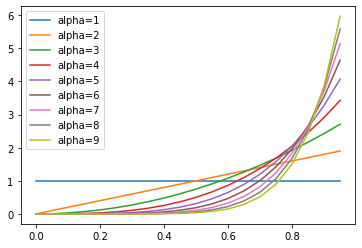

In [17]:
alphas = range(1, 10)
for alpha in alphas:
    xs = np.arange(0., 1.0, .05)
    ys = [beta_pdf(x, float(alpha), 1.) for x in xs]
    plt.plot(xs, ys, label='alpha=' + str(alpha))
plt.legend()
plt.show()


Similar experiment modulating beta:

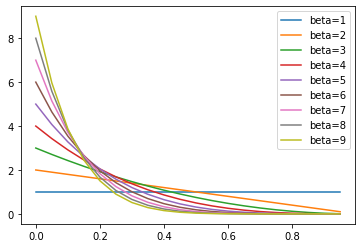

In [18]:
betas = range(1, 10)
for beta in betas:
    xs = np.arange(0., 1.0, .05)
    ys = [beta_pdf(x, 1., beta) for x in xs]
    plt.plot(xs, ys, label='beta=' + str(beta))
plt.legend()
plt.show()

Some blends!

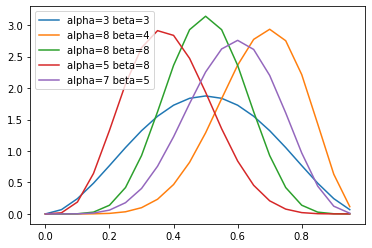

In [19]:
alphas = [random.randint(1, 8) for i in range(5)]
betas = [random.randint(1, 8) for i in range(5)]
for i, beta in enumerate(betas):
    alpha = alphas[i]
    xs = np.arange(0., 1.0, .05)
    ys = [beta_pdf(x, alpha, beta) for x in xs]
    plt.plot(xs, ys, label='alpha=' + str(alpha) + ' beta=' + str(beta))
plt.legend()
plt.show()

When using a Beta prior, you can update the distribution with Binomial observations and get a Beta posterior by simply adding the observations like so:

Prior: `X ~ Beta(10, 10)`

Posterior: `X' ~ Beta(10 + 486 , 10 + 514)` (1000 trials, 514 successes/tails)